In [36]:
import pm4py
%load_ext autoreload
%autoreload 2
import pandas as pd
import icp
import icpy
import sempler, sempler.generators
import matplotlib.pyplot as plt
import numpy as np
#import causalicp as icp
np.random.seed(12)
import networkx as nx
import datetime as dt
from sklearn.feature_selection import r_regression
from pm4py.algo.discovery.dcr_discover import algorithm as dcr_alg
from pm4py.objects.dcr.exporter import exporter as dcr_export
from data_aware_helper import *

def show_graph_with_labels(adjacency_matrix, mylabels = None):
    rows, cols = np.where(adjacency_matrix>0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.DiGraph()
    gr.add_edges_from(edges)
    if mylabels:
        nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    else:
        nx.draw(gr, node_size=500, with_labels=False)
    plt.show()

from datetime import timedelta

# Create a running example from sempler
It should be small:
- 3 input events and 1 target event: x1,x2,x3,y
- 2 data attributes: x1d1, x1d2, x2d1

The causal precedence should find: x1d, x1 and x2 as causal precedence for y

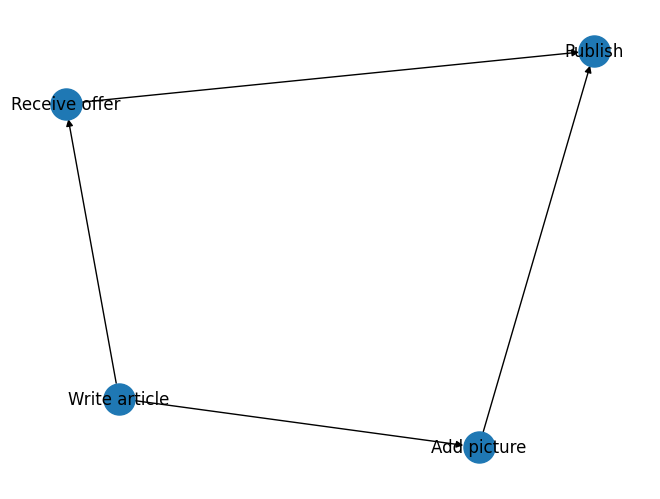

In [2]:
W = np.array([
     [0,1,1,0],
     [0,0,0,1],
     [0,0,0,1],
     [0,0,0,0]])
labels = {0:'Write article',1:'Receive offer',2:'Add picture',3:'Publish'}
show_graph_with_labels(W,labels)

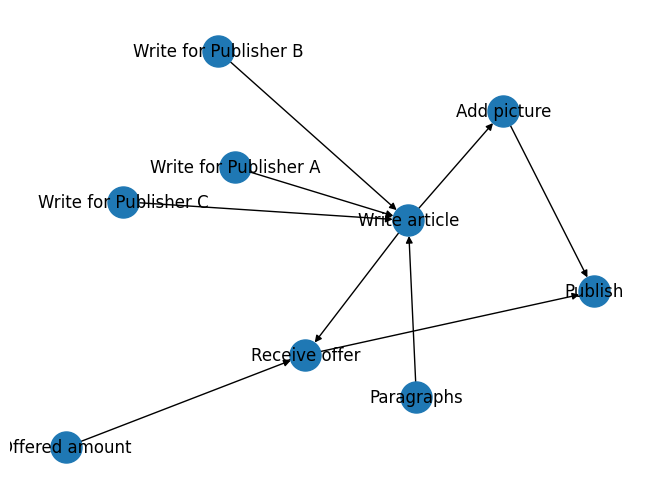

In [3]:
W = np.array([[0,0,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0,0],
     [0,0,0,0,1,0,0,0,0],
     [0,0,0,0,0,0,1,1,0],
     [0,0,0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0,0,1],
     [0,0,0,0,0,0,0,0,1],
     [0,0,0,0,0,0,0,0,0]])
labels = {0:'Write for Publisher A',1:'Write for Publisher B',2:'Write for Publisher C',3:'Paragraphs',4:'Write article',5:'Offered amount',6:'Receive offer',7:'Add picture',8:'Publish'}
show_graph_with_labels(W,labels)

# What process is this?
An event 1 with 3 options and a numerical value
An event 2 with a numerical value
An event 3 that is more or less irrelevant
An event 4 which we try to predict.

x1d1 - categorical and one hot encoded 3 values and only value 1 has an effect on the firing of v1=1 -> Y=1; v2=1 or v3=1 -> Y=0
x1d2 - numerical and random mean = 5 var = 2 (has no effect)
x2d1 - numerical with mean 20 var 10 predicts Y=1 and mean -7 with var 2 when it predicts Y=0

In [4]:
res_hist = {}
for k,v in labels.items():
    res_hist[v] = 0
for i in range(100):
    data = [np.array([
    [0,0,1,5,1,7,1,0,0],
    [1,0,0,4,1,6,1,1,0],
    [0,0,1,6,1,9,1,0,0],
    [1,0,0,5,1,9,1,1,0],
    [0,1,0,3,1,7,1,0,0],
    [0,1,0,5,1,0,0,1,0],
    [0,1,0,4,1,0,0,0,0],
    [0,0,1,6,1,0,0,1,0],
    [0,1,0,5,1,0,0,0,0],
    [0,0,1,3,1,0,0,0,0],
    [0,1,0,5,1,0,0,0,0],
        ]),np.array([
    [0,0,1,5,1,6,1,0,0],
    [0,1,0,4,1,7,1,1,0],
    [1,0,0,6,1,7,1,0,0],
    [1,0,0,5,1,8,1,1,0],
    [1,0,0,3,1,7,1,0,0],
    [1,0,0,5,1,0,0,1,1],
    [1,0,0,4,1,0,0,0,1],
    [1,0,0,6,1,0,0,1,1],
    [1,0,0,5,1,0,0,0,1],
    [1,0,0,3,1,0,0,1,1],
    [1,0,0,5,1,0,0,0,1],
        ]),np.array([
    [1,0,0,5,1,7,1,0,1],
    [1,0,0,4,1,6,1,1,1],
    [1,0,0,6,1,9,1,0,1],
    [1,0,0,5,1,9,1,1,1],
    [1,0,0,3,1,7,1,0,1],
    [1,0,0,5,1,0,0,0,1],
    [0,1,0,4,1,0,0,1,0],
    [0,0,1,6,1,0,0,0,0],
    [0,1,0,5,1,0,0,1,0],
    [0,0,1,3,1,0,0,0,0],
    [0,1,0,5,1,0,0,1,0],
        ]),np.array([
    [1,0,0,5,1,20,1,0,1],
    [1,0,0,4,1,10,1,1,1],
    [1,0,0,6,1,30,1,0,1],
    [1,0,0,5,1,20,1,1,1],
    [1,0,0,3,1,10,1,0,1],
    [1,0,0,5,1,0,0,0,1],
    [1,0,0,4,1,20,1,1,1],
    [1,0,0,6,1,20,1,0,1],
    [1,0,0,5,1,10,1,1,1],
    [1,0,0,3,1,20,1,0,1],
    [1,0,0,5,1,20,1,1,1],
        ])]
    noise = [np.random.normal(0,0.1,data[0].shape)]
    noise += [np.random.normal(0,0.1,data[1].shape)]
    noise += [np.random.normal(0,0.1,data[2].shape)]
    noise += [np.random.normal(0,0.1,data[3].shape)]
    data[0] = data[0] + noise[0]
    data[1] = data[1] + noise[1]
    data[2] = data[2] + noise[2]
    data[3] = data[3] + noise[3]
    result = icp.fit([data[0],data[1],data[2],data[3]], 8, alpha=0.05, precompute=True, verbose=False, color=False)
    if result.estimate:
        for x in result.estimate:
            res_hist[labels[x]] += 1
        print(f'[i={i}] Parental set {[labels[x] for x in result.estimate]} for {labels[result.target]}')
for k,v in dict(sorted(res_hist.items(), key=lambda item: item[1])).items():
    print(f'[res] {k}:{v}')

[i=0] Parental set ['Offered amount'] for Publish
[i=1] Parental set ['Offered amount'] for Publish
[i=3] Parental set ['Write for Publisher B', 'Write for Publisher C'] for Publish
[i=5] Parental set ['Offered amount', 'Receive offer'] for Publish
[i=6] Parental set ['Write for Publisher B', 'Write for Publisher C', 'Offered amount', 'Receive offer'] for Publish
[i=7] Parental set ['Offered amount', 'Receive offer'] for Publish
[i=8] Parental set ['Write for Publisher B', 'Write for Publisher C', 'Receive offer'] for Publish
[i=9] Parental set ['Offered amount', 'Receive offer'] for Publish
[i=11] Parental set ['Offered amount'] for Publish
[i=12] Parental set ['Offered amount'] for Publish
[i=13] Parental set ['Offered amount'] for Publish
[i=15] Parental set ['Offered amount', 'Receive offer'] for Publish
[i=16] Parental set ['Offered amount', 'Receive offer'] for Publish
[i=17] Parental set ['Write for Publisher A', 'Offered amount', 'Receive offer'] for Publish
[i=18] Parental set

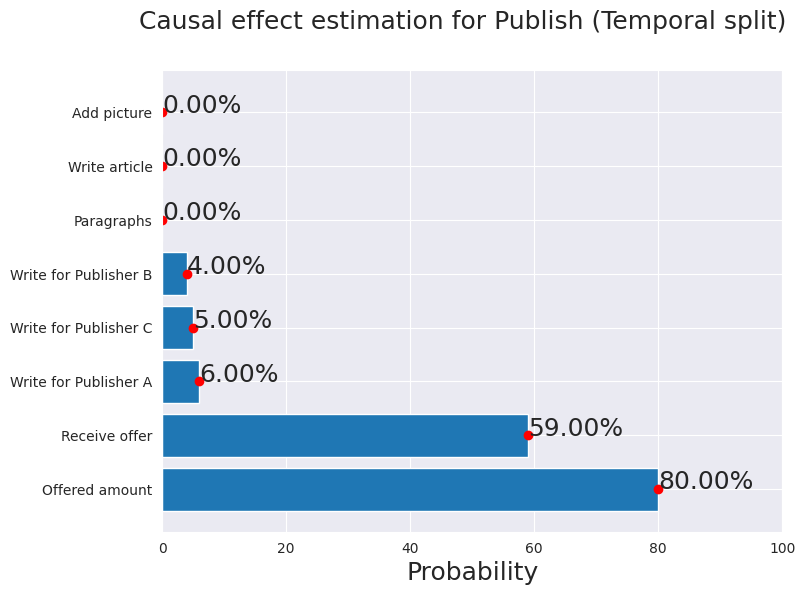

In [5]:
res_hist.pop('Publish')
res_hist = {k: v for k, v in sorted(res_hist.items(),reverse=True, key=lambda item: item[1])}
n = len(res_hist)
p= [v for k,v in res_hist.items()]
x = np.arange(n)

fig = plt.figure(figsize=(8, 6))
plt.barh(x, p)
plt.scatter(p,x, marker='o', color='red')
for i, txt in enumerate(p):
    plt.annotate('{:.2f}%'.format(txt), (p[i], x[i]), fontsize=18)
plt.yticks(ticks=x, labels=[k for k,v in res_hist.items()])
plt.suptitle(f'Causal effect estimation for {labels[result.target]} (Temporal split)', fontsize = 18)
# plt.ylabel(f'Causal effect estimation for {cols[res.target]}', fontsize = 18)
plt.xlabel('Probability', fontsize=18)
plt.xlim([0, 100])
# plt.legend(loc=(0.5,0.8), fontsize = 15)
plt.show()

In [42]:
data = [np.array([
    [0,0,1,5,1,7,1,0,0],
    [1,0,0,4,1,6,1,1,0],
    [0,0,1,6,1,9,1,0,0],
    [1,0,0,5,1,9,1,1,0],
    [0,1,0,3,1,7,1,0,0],
    [0,1,0,5,1,0,0,1,0],
    [0,1,0,4,1,0,0,0,0],
    [0,0,1,6,1,0,0,1,0],
    [0,1,0,5,1,0,0,0,0],
    [0,0,1,3,1,0,0,0,0],
    [0,1,0,5,1,0,0,0,0],
        ]),np.array([
    [0,0,1,5,1,6,1,0,0],
    [0,1,0,4,1,7,1,1,0],
    [1,0,0,6,1,7,1,0,0],
    [1,0,0,5,1,8,1,1,0],
    [1,0,0,3,1,7,1,0,0],
    [1,0,0,5,1,0,0,1,1],
    [1,0,0,4,1,0,0,0,1],
    [1,0,0,6,1,0,0,1,1],
    [1,0,0,5,1,0,0,0,1],
    [1,0,0,3,1,0,0,1,1],
    [1,0,0,5,1,0,0,0,1],
        ]),np.array([
    [1,0,0,5,1,7,1,0,1],
    [1,0,0,4,1,6,1,1,1],
    [1,0,0,6,1,9,1,0,1],
    [1,0,0,5,1,9,1,1,1],
    [1,0,0,3,1,7,1,0,1],
    [1,0,0,5,1,0,0,0,1],
    [0,1,0,4,1,0,0,1,0],
    [0,0,1,6,1,0,0,0,0],
    [0,1,0,5,1,0,0,1,0],
    [0,0,1,3,1,0,0,0,0],
    [0,1,0,5,1,0,0,1,0],
        ]),np.array([
    [1,0,0,5,1,20,1,0,1],
    [1,0,0,4,1,10,1,1,1],
    [1,0,0,6,1,30,1,0,1],
    [1,0,0,5,1,20,1,1,1],
    [1,0,0,3,1,10,1,0,1],
    [1,0,0,5,1,0,0,0,1],
    [1,0,0,4,1,20,1,1,1],
    [1,0,0,6,1,20,1,0,1],
    [1,0,0,5,1,10,1,1,1],
    [1,0,0,3,1,20,1,0,1],
    [1,0,0,5,1,20,1,1,1],
        ])]
log = np.concatenate(data)
log = pd.DataFrame(log)
log = log.rename(columns=labels)
for p in ['A','B','C']:
    log.loc[log[f'Write for Publisher {p}']==1, f'Write for Publisher {p}'] = p
    log.loc[log[f'Write for Publisher {p}']==0, f'Write for Publisher {p}'] = ''
log['Publisher'] = log['Write for Publisher A'] + log['Write for Publisher B'] + log['Write for Publisher C']
log = log.drop(['Write for Publisher A','Write for Publisher B','Write for Publisher C'],axis=1)
log['case:concept:name'] = log.index
log['case:concept:name'] = log['case:concept:name'].apply(str)
events = ['Write article','Receive offer','Add picture','Publish']
for event in events:
    log.loc[log[event]==1, event] = event
wa_log = log[log['Write article']!=0][['case:concept:name','Write article','Publisher','Paragraphs']].rename(columns= {'Write article':'concept:name'})
time = 10
wa_log['time:timestamp'] = dt.datetime.strptime(f'2024-01-{time}','%Y-%m-%d')
ap_log = log[log['Add picture']!=0][['case:concept:name','Add picture']].rename(columns= {'Add picture':'concept:name'})
ap_log['time:timestamp'] = np.random.randint(1,5,size=len(ap_log))
ap_log['time:timestamp'] = ap_log['time:timestamp'].apply(lambda x : dt.datetime.strptime(f'2024-01-{time+x}','%Y-%m-%d') )
ro_log = log[log['Receive offer']!=0][['case:concept:name','Receive offer','Offered amount']].rename(columns= {'Receive offer':'concept:name'})
ro_log['time:timestamp'] = np.random.randint(1,5,size=len(ro_log))
ro_log['time:timestamp'] = ro_log['time:timestamp'].apply(lambda x : dt.datetime.strptime(f'2024-01-{time+x}','%Y-%m-%d') )
pu_log = log[log['Publish']!=0][['case:concept:name','Publish']].rename(columns= {'Publish':'concept:name'})
pu_log['time:timestamp'] = np.random.randint(10,15,size=len(pu_log))
pu_log['time:timestamp'] = pu_log['time:timestamp'].apply(lambda x : dt.datetime.strptime(f'2024-01-{time+x}','%Y-%m-%d') )
log = pd.concat([wa_log,ap_log,ro_log,pu_log])
log = log.sort_values(['case:concept:name','time:timestamp'])
log.loc[(log.index<=22) & (log.index>11),'time:timestamp'] += timedelta(weeks=4)
log.loc[(log.index<=33) & (log.index>22),'time:timestamp'] += timedelta(weeks=8)
log.loc[(log.index<=44) & (log.index>33),'time:timestamp'] += timedelta(weeks=12)
log

In [44]:
pm4py.write_xes(log,'../models/bpm24_running_example.xes')

exporting log, completed traces ::   0%|          | 0/44 [00:00<?, ?it/s]

In [45]:
dcr_model, log_abs = dcr_alg.apply(log)
dcr_export.apply(dcr_model,'../models/bpm24.xml')

[i] Mining with basic DisCoveR
[i] Converting to old event log!


/home/vco/Projects/pm4py-dcr/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [8]:
events = set(log['concept:name'].unique())
data_attributes = set(log.columns).difference({'org:resource','lifecycle:transition','concept:name','time:timestamp','case:concept:name'})
event_data_attributes = {}
for event in events:
    event_data_attributes[event] = extract_event_data_attributes(log,event,data_attributes)
domain_knowledge = {
    'Write article': {'Publisher':'categorical','Paragraphs':'numerical'},
    'Receive offer': {'Offered amount':'numerical'}
}
events_no_data = set(log['concept:name'].unique()).difference(domain_knowledge.keys())
events_and_data = set(log['concept:name'].unique())

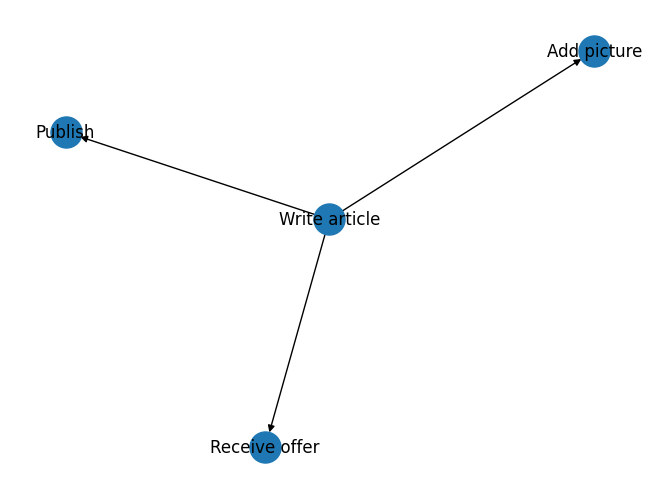

In [9]:
data_filler_adj_matrix = {}
i = len(events)
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

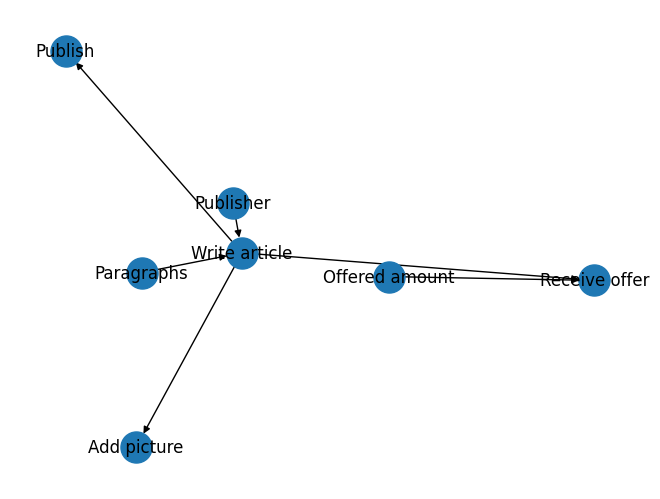

In [10]:
events_and_data = set(log['concept:name'].unique())
data_filler_adj_matrix = {}
i = len(events)
for e,a in domain_knowledge.items():
    ks = set()
    for k,v in a.items():
        if v!='ignore':
            events_and_data.add(k)
            i += 1
            ks.add(k)
    data_filler_adj_matrix[e] = ks
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

In [11]:
events = set(log['concept:name'].unique())
event_and_data_functions = {}
event_and_plot_info = {}
for event in events:
    res = extract_event_binomial(event,log, unfolded=False)
    for etemp, (func, prob) in res.items():
        event_and_data_functions[etemp] = func
        event_and_plot_info[etemp] = prob
attribute_events = {}
attribute_data_type = {}
for event, attributes in domain_knowledge.items():
    for attr, data_type in attributes.items():
        if attr not in attribute_events.keys():
            attribute_events[attr] = [event]
            attribute_data_type[attr] = data_type
        else:
            attribute_events[attr].append(event)

for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        event_and_data_functions[attr], pdict = extract_categorical_data_attribute(attribute_events[attr],attr,log)
        event_and_plot_info[attr] = pdict
    elif data_type == 'numerical':
        event_and_data_functions[attr] = extract_numerical_data_attribute(attribute_events[attr],attr,log)
observational_data_list = []

n = log['case:concept:name'].nunique()
for i, case_df in enumerate(log.groupby('case:concept:name')):
    data_dict = case_to_data_entry(case_df[1],events,attribute_data_type)
    observational_data_list.append(data_dict)
    # print(f'[i] {i+1}/{n} cid: {case_df[0]}')
    if i+1 == 10000:
        break
event_x_cols = {}
event_y_cols = {}

instant_effects = True

for event in events:
    precedence_events = set(log_abs['precedenceFor'][event])
    precedence_data_attributes = set()
    for precedence_event in precedence_events:
        if precedence_event in data_filler_adj_matrix:
            precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[precedence_event]))
    if instant_effects and event in data_filler_adj_matrix:
        precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[event]))
    precedence_events = precedence_events.union(precedence_data_attributes)
    event_x_cols[event] = precedence_events
    event_y_cols[event] = event

[i] Event Add picture prob of success: 0.43
[i] Event Write article prob of success: 1.00
[i] Event Receive offer prob of success: 0.57
[i] Event Publish prob of success: 0.52
[i] For categorical data attribute: Publisher
[i] Data instance A prob of success 0.64
[i] Data instance B prob of success 0.20
[i] Data instance C prob of success 0.16


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 33.07it/s]


[i] For numerical data attribute: Paragraphs dist:uniform params:{'loc': 3.0, 'scale': 3.0}


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 42.14it/s]

[i] For numerical data attribute: Offered amount dist:expon params:{'loc': 6.0, 'scale': 5.640000000000001}


data[0] - publish = 1
data[1] - publisher = A
data[2] - receive offer = 1
data[3] - amount > 10

In [12]:
event_model = {}
event_model_input = {}

y_col = 'Publish'
x_cols = events_and_data.difference(set([y_col]))

# always_executed_events = get_always_executed_events()
tts_num = int(len(observational_data_list)*(2/3))

observational_data = pd.DataFrame(observational_data_list,columns=list(event_and_data_functions.keys()))
observational_data = observational_data.fillna(0)
# x_cols = deepcopy(event_x_cols[event])
# y_cols = deepcopy(event_y_cols[event])

for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        onehot = pd.get_dummies(observational_data[attr],dummy_na=False,prefix=attr)
        observational_data = pd.concat([observational_data,onehot],axis=1)
        observational_data = observational_data.drop(attr,axis=1)

        x_cols.discard(attr)
        x_cols = x_cols.union(set(onehot.columns))

x_cols_list = list(x_cols)
print(x_cols_list)

['Receive offer', 'Publisher_C', 'Offered amount', 'Add picture', 'Write article', 'Paragraphs', 'Publisher_A', 'Publisher_B']


In [13]:
import icp

In [14]:
clf = LogisticRegression(max_iter=1000)
model = clf.fit(observational_data[x_cols_list][:tts_num], observational_data[y_col][:tts_num])
print(f'[i] Fit logistic regression score: {model.score(observational_data[x_cols_list][tts_num:],observational_data[y_col][tts_num:])}')
# event_model[event] = model
# event_model_input[event] = deepcopy(x_cols)
# event_model_input[event].add(y_cols)
# y_hat = model.predict(observational_data[list(x_cols)][8000:])
# cols = list(x_cols)
noise_mean = 0
noise_variance = 0.1
#what are the different environments on which we split our observational data
# each data set is a different environment
# we assume that the change in values has an effect on the target event
cols = list(x_cols)
cols.append(y_col)
target_idx = cols.index(y_col)
res_hist = {}
for v in x_cols_list:
    res_hist[v] = 0
for i in range(100):
    data = [observational_data[observational_data['Publisher_A']!=1][cols].to_numpy()]
    data += [observational_data[observational_data['Publisher_A']==1][cols].to_numpy()]
    data += [observational_data[observational_data['Offered amount']<10][cols].to_numpy()]
    data += [observational_data[observational_data['Offered amount']>10][cols].to_numpy()]
    data += [observational_data[observational_data['Add picture']==0][cols].to_numpy()]
    data += [observational_data[observational_data['Add picture']==1][cols].to_numpy()]

    noise = [np.random.normal(0,0.1,data[0].shape)]
    data[0] = data[0] + noise[0]
    for k in range(len(data)-1):
        noise += [np.random.normal(0,0.1,data[k+1].shape)]
        data[k+1] = data[k+1] + noise[k+1]
    
    # noise = [np.random.normal(noise_mean,noise_variance,data[0].shape)]
    # noise += [np.random.normal(noise_mean,noise_variance,data[1].shape)]
    # noise += [np.random.normal(noise_mean,noise_variance,data[2].shape)]
    # noise += [np.random.normal(noise_mean,noise_variance,data[3].shape)]
    # noise += [np.random.normal(noise_mean,noise_variance,data[4].shape)]
    # noise += [np.random.normal(noise_mean,noise_variance,data[5].shape)]
    # 
    # data[0] = data[0] + noise[0]
    # data[1] = data[1] + noise[1]
    # data[2] = data[2] + noise[2]
    # data[3] = data[3] + noise[3]
    # data[4] = data[4] + noise[4]
    # data[5] = data[5] + noise[5]
    
    res = icp.fit(data,target=target_idx, precompute=True, verbose=False, color=False)
    if res.estimate:
        print(f'[i={i}] {[cols[k] for k in res.estimate]} causal effect for "{cols[res.target]}"')
        # print(f'[i={i}] {res.conf_intervals} {res.pvalues}')
        # print(f'[i={i}] coef: {res.coefficients}')
        for x in res.estimate:
            res_hist[x_cols_list[x]] += 1
for k,v in dict(sorted(res_hist.items(), key=lambda item: item[1])).items():
    print(f'[res] {k}:{v}')

[i] Fit logistic regression score: 1.0
[i=1] ['Offered amount'] causal effect for "Publish"
[i=3] ['Receive offer', 'Publisher_C', 'Offered amount', 'Publisher_B'] causal effect for "Publish"
[i=5] ['Receive offer', 'Publisher_C', 'Offered amount', 'Publisher_B'] causal effect for "Publish"
[i=6] ['Receive offer', 'Offered amount', 'Publisher_B'] causal effect for "Publish"
[i=7] ['Receive offer', 'Publisher_C', 'Offered amount', 'Write article', 'Publisher_B'] causal effect for "Publish"
[i=8] ['Receive offer', 'Offered amount'] causal effect for "Publish"
[i=9] ['Offered amount', 'Publisher_B'] causal effect for "Publish"
[i=10] ['Receive offer', 'Offered amount'] causal effect for "Publish"
[i=11] ['Receive offer', 'Publisher_C', 'Offered amount', 'Paragraphs', 'Publisher_B'] causal effect for "Publish"
[i=12] ['Write article'] causal effect for "Publish"
[i=13] ['Publisher_C', 'Offered amount', 'Publisher_B'] causal effect for "Publish"
[i=14] ['Offered amount', 'Publisher_B'] caus

In [25]:
observational_data

,Add picture,Write article,Receive offer,Publish,Paragraphs,Offered amount,Publisher_A,Publisher_B,Publisher_C
0,0,1,1,0,5.0,7.0,0,0,1
1,1,1,1,0,4.0,6.0,1,0,0
2,0,1,0,0,5.0,0.0,0,1,0
3,0,1,1,0,5.0,6.0,0,0,1
4,1,1,1,0,4.0,7.0,0,1,0
5,0,1,1,0,6.0,7.0,1,0,0
6,1,1,1,0,5.0,8.0,1,0,0
7,0,1,1,0,3.0,7.0,1,0,0
8,1,1,0,1,5.0,0.0,1,0,0
9,0,1,0,1,4.0,0.0,1,0,0


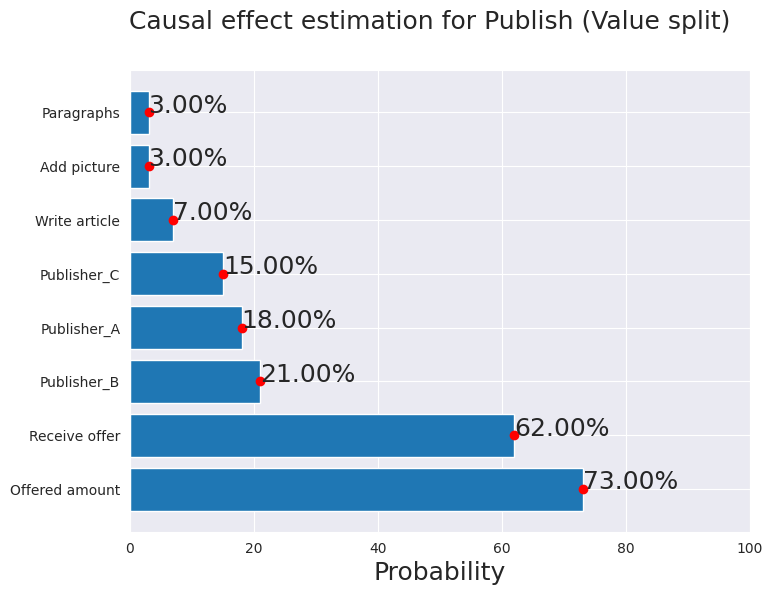

In [15]:
res_hist = {k: v for k, v in sorted(res_hist.items(),reverse=True, key=lambda item: item[1])}
n = len(res_hist)
p= [v for k,v in res_hist.items()]
x = np.arange(n)

fig = plt.figure(figsize=(8, 6))
plt.barh(x, p)
plt.scatter(p,x, marker='o', color='red')
for i, txt in enumerate(p):
    plt.annotate('{:.2f}%'.format(txt), (p[i], x[i]), fontsize=18)
plt.yticks(ticks=x, labels=[k for k,v in res_hist.items()])
plt.suptitle(f'Causal effect estimation for {cols[res.target]} (Value split)', fontsize = 18)
# plt.ylabel(f'Causal effect estimation for {cols[res.target]}', fontsize = 18)
plt.xlabel('Probability', fontsize=18)
plt.xlim([0, 100])
# plt.legend(loc=(0.5,0.8), fontsize = 15)
plt.show()

# Correlation

In [16]:
pcc = r_regression(observational_data[x_cols_list], observational_data[y_col]).reshape((1,8))
pcc_df = pd.DataFrame(pcc,columns=x_cols_list)
pcc_df[['Write article','Paragraphs','Publisher_A','Publisher_B','Publisher_C','Receive offer','Offered amount','Add picture']]

,Write article,Paragraphs,Publisher_A,Publisher_B,Publisher_C,Receive offer,Offered amount,Add picture
0,inf,0.016899,0.791107,-0.530691,-0.4552,0.177459,0.396578,0.006263


In [17]:
def make_pretty(styler):
    styler.text_align = 'right'
    styler.precision = 2
    styler.background_gradient(axis=None, vmin=-1, vmax=1, cmap="YlGnBu")
    return styler

In [18]:
order = ['Publish','Write article','Paragraphs','Publisher_A','Publisher_B','Publisher_C','Receive offer','Offered amount','Add picture']
observational_data[order].corr(method='pearson').fillna('-')#.style.pipe(make_pretty)

,Publish,Write article,Paragraphs,Publisher_A,Publisher_B,Publisher_C,Receive offer,Offered amount,Add picture
Publish,1.0,-,0.016899,0.791107,-0.530691,-0.4552,0.177459,0.396578,0.006263
Write article,-,-,-,-,-,-,-,-,-
Paragraphs,0.016899,-,1.0,0.008773,-0.099396,0.098078,-0.042601,0.091558,0.042601
Publisher_A,0.791107,-,0.008773,1.0,-0.67082,-0.575396,0.390199,0.436351,0.086711
Publisher_B,-0.530691,-,-0.099396,-0.67082,1.0,-0.220564,-0.354175,-0.339297,0.126676
Publisher_C,-0.4552,-,0.098078,-0.575396,-0.220564,1.0,-0.122595,-0.199702,-0.253743
Receive offer,0.177459,-,-0.042601,0.390199,-0.354175,-0.122595,1.0,0.7627,0.018947
Offered amount,0.396578,-,0.091558,0.436351,-0.339297,-0.199702,0.7627,1.0,-0.004
Add picture,0.006263,-,0.042601,0.086711,0.126676,-0.253743,0.018947,-0.004,1.0


In [19]:
observational_data[order].corr(method='spearman').fillna('-')

,Publish,Write article,Paragraphs,Publisher_A,Publisher_B,Publisher_C,Receive offer,Offered amount,Add picture
Publish,1.0,-,0.015206,0.791107,-0.530691,-0.4552,0.177459,0.358333,0.006263
Write article,-,-,-,-,-,-,-,-,-
Paragraphs,0.015206,-,1.0,0.007894,-0.131802,0.134971,-0.038333,0.052453,-0.007667
Publisher_A,0.791107,-,0.007894,1.0,-0.67082,-0.575396,0.390199,0.461675,0.086711
Publisher_B,-0.530691,-,-0.131802,-0.67082,1.0,-0.220564,-0.354175,-0.374023,0.126676
Publisher_C,-0.4552,-,0.134971,-0.575396,-0.220564,1.0,-0.122595,-0.194711,-0.253743
Receive offer,0.177459,-,-0.038333,0.390199,-0.354175,-0.122595,1.0,0.898616,0.018947
Offered amount,0.358333,-,0.052453,0.461675,-0.374023,-0.194711,0.898616,1.0,0.034053
Add picture,0.006263,-,-0.007667,0.086711,0.126676,-0.253743,0.018947,0.034053,1.0


In [20]:
observational_data[order].corr(method='kendall').fillna('-')

,Publish,Write article,Paragraphs,Publisher_A,Publisher_B,Publisher_C,Receive offer,Offered amount,Add picture
Publish,1.0,-,0.014042,0.791107,-0.530691,-0.4552,0.177459,0.322324,0.006263
Write article,-,1.0,-,-,-,-,-,-,-
Paragraphs,0.014042,-,1.0,0.00729,-0.121716,0.124643,-0.0354,0.038629,-0.00708
Publisher_A,0.791107,-,0.00729,1.0,-0.67082,-0.575396,0.390199,0.415281,0.086711
Publisher_B,-0.530691,-,-0.121716,-0.67082,1.0,-0.220564,-0.354175,-0.336437,0.126676
Publisher_C,-0.4552,-,0.124643,-0.575396,-0.220564,1.0,-0.122595,-0.175145,-0.253743
Receive offer,0.177459,-,-0.0354,0.390199,-0.354175,-0.122595,1.0,0.808313,0.018947
Offered amount,0.322324,-,0.038629,0.415281,-0.336437,-0.175145,0.808313,1.0,0.030631
Add picture,0.006263,-,-0.00708,0.086711,0.126676,-0.253743,0.018947,0.030631,1.0


# Visualize
Events

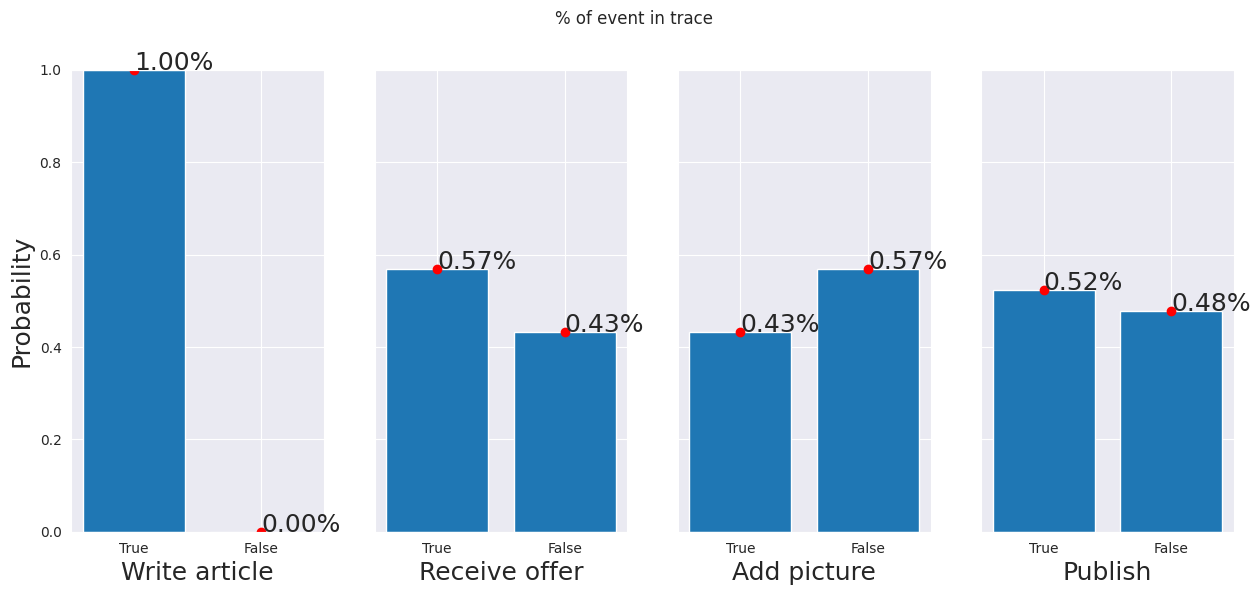

In [21]:
fig, axs = plt.subplots(1, 4,figsize=(15,6),sharey=True,sharex=True)
fig.suptitle('% of event in trace')
axs[0].set_ylabel('Probability', fontsize=18)
for i, event in enumerate(['Write article','Receive offer','Add picture','Publish']):
    p = event_and_plot_info[event]
    p = [p,1-p]
    x = [0,1]
    axs[i].bar(x, p)
    axs[i].scatter(x, p, marker='o', color='red')
    for k, txt in enumerate(p):
        axs[i].annotate('{:.2f}%'.format(txt), (x[k], p[k]), fontsize=18)
    axs[i].set_xticks(ticks=x, labels=['True','False'])
    axs[i].set_xlabel(event, fontsize = 18)
    axs[i].set_ylim([0, 1])
    # plt.legend(loc=(0.5,0.8), fontsize = 15)
plt.show()

# Categorical

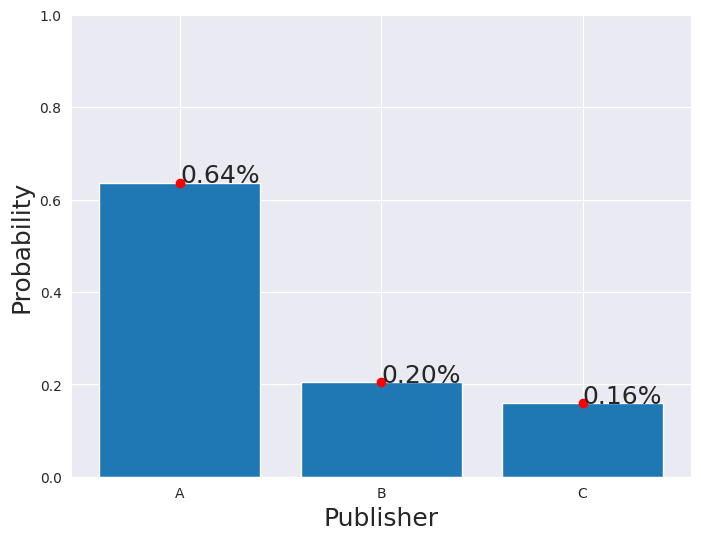

In [22]:
attr = 'Publisher'
n = len(event_and_plot_info[attr])
p= [v for k,v in event_and_plot_info[attr].items()]
x = np.arange(n)

fig = plt.figure(figsize=(8, 6))
plt.bar(x, p)
plt.scatter(x, p, marker='o', color='red')
for i, txt in enumerate(p):
    plt.annotate('{:.2f}%'.format(txt), (x[i], p[i]), fontsize=18)
plt.xticks(ticks=x, labels=[k for k,v in event_and_plot_info[attr].items()])
plt.xlabel(attr, fontsize = 18)
plt.ylabel('Probability', fontsize=18)
plt.ylim([0, 1])
# plt.legend(loc=(0.5,0.8), fontsize = 15)
plt.show()

# Numerical

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 38.47it/s]


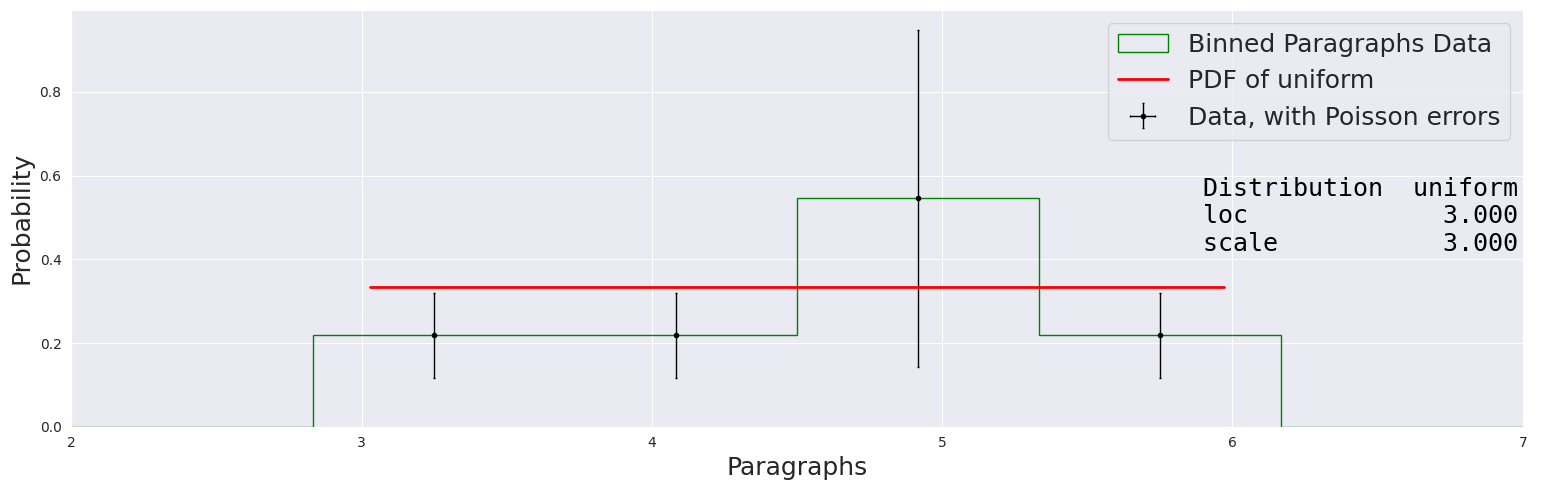

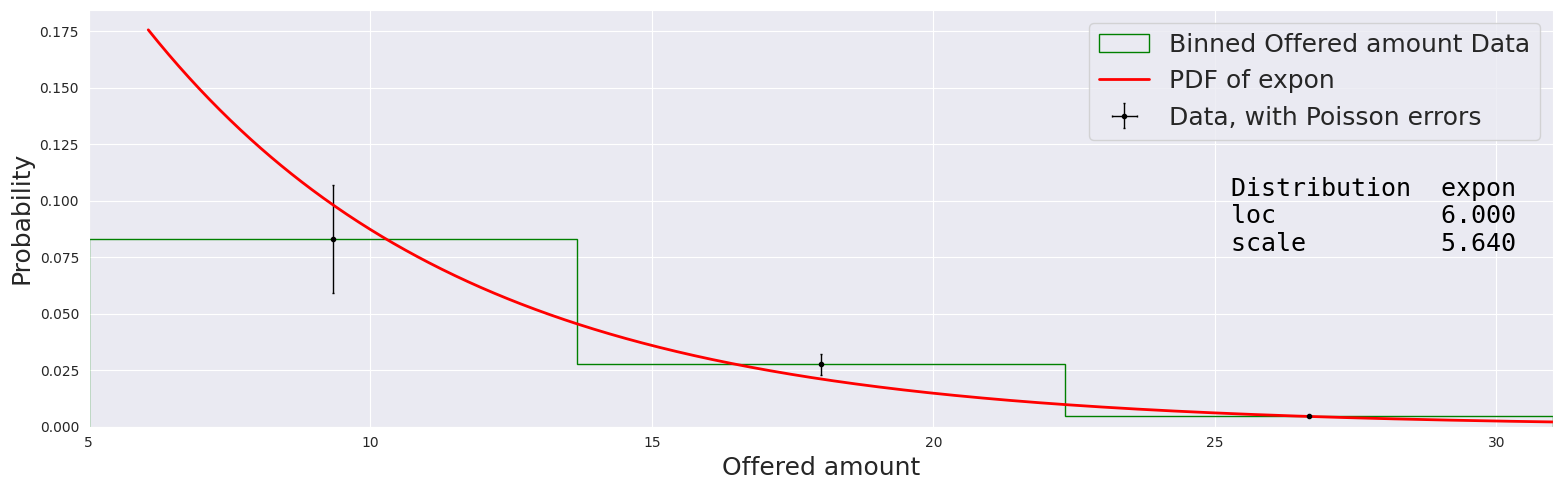

In [23]:
parent_event_dict = {v1:k for k,v in domain_knowledge.items() for v1, _ in v.items()}

for data_attribute in ['Paragraphs','Offered amount']: 
    density = True
    paradata = log[log['concept:name'].isin([parent_event_dict[data_attribute]]) & log[data_attribute].notna()][data_attribute]
    xmin = min(paradata)-1
    xmax = max(paradata)+1
    Nbins, binwidth = freedman_diaconis_rule(paradata)
    counts, bin_edges = np.histogram(paradata, bins=Nbins, range=(xmin, xmax),density=density)
    x = (bin_edges[1:][counts > 0] + bin_edges[:-1][counts > 0]) / 2
    y = counts[counts > 0]
    sy = np.sqrt(counts[counts > 0])
    if density:
        sy = sy*counts[counts > 0]
    fig, ax = plt.subplots(figsize=(16, 5))
    counts, bins, bars = ax.hist(paradata, bins=Nbins, range=(xmin, xmax), histtype='step',
                                                     density=density, alpha=1, color='g',
                                                     label=f'Binned {data_attribute} Data')
    ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',
                                   ecolor='k',
                                   elinewidth=1, capsize=1, capthick=1)
    f = Fitter(paradata, distributions=get_common_distributions(),timeout=2*60,bins=Nbins,density=density)
    f.fit()
    # here you get the rss fit scores
    res = f.summary(plot=False)
    residual_sumssquare_error = res.iloc[0].sumsquare_error
    aic = res.iloc[0].aic
    kl_div = res.iloc[0].kl_div
    best_dist, fitted_params = f.get_best().popitem()

    size = 1000
    dist_func = getattr(stats,best_dist)
    start = dist_func.ppf(0.01, **fitted_params)
    end = dist_func.ppf(0.99, **fitted_params)
    x = np.linspace(start, end, size)
    y = dist_func.pdf(x, **fitted_params)
    pdf = pd.Series(y, x)
    pdf.plot(lw=2, label=f'PDF of {best_dist}', color='r', legend=True)

    # ax.plot(f.fitted_pdf[best_dist],label=f'Best fit {best_dist}')
    d = {'Distribution':f'{best_dist}',
         **fitted_params}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.78, 0.6, text, ax, fontsize=18)
    ax.set_xlabel(f'{data_attribute}', fontsize=18)
    ax.set_ylabel('Probability', fontsize=18)
    ax.set_xlim([xmin,xmax])
    # ax.set_ylim([0,0.012])

    # ax.set_title(f'Numerical data fit for {data_attribute}"')
    ax.legend(fontsize=18)
    fig.tight_layout()

# Other

In [24]:
# Generate a random graph and construct a linear-Gaussian SCM
W = sempler.generators.dag_avg_deg(7, 3, random_state=42)
m = np.array([0,0,0,0,0,0,0])
v = np.array([1,1,1,1,1,1,1])
scm = sempler.LGANM(W, m, v)